Create the scaled CO2 emissions for the initial 2015-2024 period of the AERA experiment

In [1]:
import xarray as xr, xarray_tools as xrt, numpy as np, pandas as pd
import iris, iris.coord_categorisation, iris.plot as iplt
import matplotlib.pyplot as plt
import aera
import mule


In [2]:
df = aera.get_base_df()
print(df)

Use the following non-CO2 RF file: /home/599/mrd599/.local/lib/python3.9/site-packages/aera/data/nonco2_rf_ssp126_v1.dat
Use the following non-CO2 emission file: /home/599/mrd599/.local/lib/python3.9/site-packages/aera/data/nonco2_emis_ssp126_v3.dat
Use the following land use emission file: /home/599/mrd599/.local/lib/python3.9/site-packages/aera/data/lu_emis_ssp126_bern3d_adj_GCB2020_v1.dat
Use the following historical fossil fuel CO2 emission file: /home/599/mrd599/.local/lib/python3.9/site-packages/aera/data/co2_ff_GCP_plus_NDC_v1.dat
Use the following historical N2O concentration file: /home/599/mrd599/.local/lib/python3.9/site-packages/aera/data/n2o_conc_ssp126_v1.dat
      rf_non_co2  non_co2_emission  lu_emission  ff_emission  temp  co2_conc  \
year                                                                           
1751         NaN               NaN          NaN        0.003   NaN       NaN   
1752         NaN               NaN          NaN        0.003   NaN       NaN  

In [3]:
co2 = iris.load_cube('/g/data1a/p66/txz599/data/ancil/CMIP6/CO2_fluxes_ESM_1750_2014.anc')
co2.coord('latitude').guess_bounds()
co2.coord('longitude').guess_bounds()
areacella = iris.load_cube('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/fx/areacella/gn/latest/areacella_fx_ACCESS-ESM1-5_piControl_r1i1p1f1_gn.nc')

In [4]:
iris.coord_categorisation.add_year(co2,'time')
co2_ann = co2.aggregated_by(['year'], iris.analysis.MEAN)

In [5]:
grid_areas = iris.util.broadcast_to_shape(areacella.data, co2_ann.shape, [1,2])
co2_g = co2_ann.collapsed(['latitude', 'longitude'], iris.analysis.MEAN, weights=grid_areas)
# This is kg/m^2/s of CO2
# Convert to Pg C / year to match AERA emissions
area_tot = areacella.collapsed(['latitude', 'longitude'], iris.analysis.SUM).data
# Pg / year = 1e12 kg/year
# Convert from CO2 to C with factor 12/44
C_g = co2_g * area_tot  * 86400 * 365 * 1e-12 * 12 / 44

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/iris/cube.py:3769: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))


In [8]:
C_g[-1].data

array(9.84576214)

In [10]:
# Convert to a compatible dataframe
FF_esm15 = pd.DataFrame(C_g.data, index = np.arange(1750,2015), columns = ['ff_emission'])

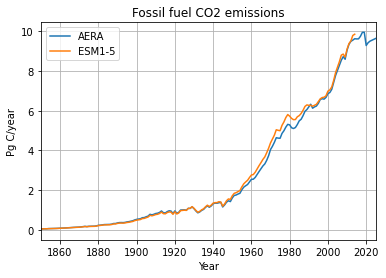

In [11]:
fig, axes = plt.subplots()
df['ff_emission'].plot(label='AERA')
FF_esm15['ff_emission'].plot(label='ESM1-5')
axes.set_title('Fossil fuel CO2 emissions')
axes.legend()
axes.set_ylabel('Pg C/year')
axes.set_xlabel('Year')
axes.set_xlim(1850,2025)
axes.grid(True)

In [28]:
i_2014 = len(co2.data) - 12
print(co2[i_2014])

m01s00i251 / (unknown)              (latitude: 145; longitude: 192)
    Dimension coordinates:
        latitude                             x               -
        longitude                            -               x
    Scalar coordinates:
        time                        2014-01-15 00:00:00
        year                        2014
    Attributes:
        STASH                       m01s00i251


In [29]:
firstyr = 2014 # Model needs this for initial interpolation
lastyr = 2025
n_times = 12*(lastyr-firstyr+1)
n_levs = 38
n_cols = 192
n_rows = 145
template = {
    'fixed_length_header':{
        'data_set_format_version': 20,  # Always fixed
        'sub_model': 1,                 # Atmosphere
        'vert_coord_type': 1,           # Hybrid heights
        'horiz_grid_type': 0,           # Global file
        'dataset_type': 4,              # Ancillary
        'calendar' : 1,                 # Gregorian
        'grid_staggering': 3,           # ND
        'time_type' : 1,                # Time series
        'model_version': 703,
        't1_year' : firstyr,
        't1_month' : 1,
        't1_day' : 16,
        't1_hour' : 0,
        't1_minute' : 0,
        't1_second' : 0,
        't1_year_day_number' : 0,
        't2_year' : firstyr + (n_times//12)-1,
        't2_month' : 12,
        't2_day' : 16,
        't2_minute' : 0,
        't2_second' : 0,
        't2_year_day_number' : 0,
        't3_year' : 0,
        't3_month' : 1,
        't3_day' : 0,
        't3_minute' : 0,
        't3_second' : 0,
        't3_year_day_number' : 0,
        },
    'integer_constants':{
        'num_times' : n_times,
        'num_levels': 1,
        'num_cols': n_cols,
        'num_rows': n_rows
        },
    'real_constants':{
        'col_spacing': 360.0/n_cols,
        'row_spacing': 180.0/(n_rows-1),
        'start_lat': -90.0,
        'start_lon': 0.0,
        'north_pole_lat': 90.0,
        'north_pole_lon': 0.0,
        },
    }

new_ff = mule.AncilFile.from_template(template)

# new_ff.level_dependent_constants = \
#     mule.ancil.Ancil_LevelDependentConstants.empty(new_ff.integer_constants.num_levels)

itime = 0
for year in range(2014,lastyr+1):
    if year == 2014:
        scale_factor = 1.0
    else:
        scale_factor = df['ff_emission'][year] / FF_esm15['ff_emission'][2014]
    for mon in range(12):

        new_field = mule.Field2.empty()

        # To correspond to the header-release 3 class used
        new_field.lbrel = 2

        # Several of the settings can be copied from the file object
        new_field.lbnpt = new_ff.integer_constants.num_cols
        new_field.lbrow = new_ff.integer_constants.num_rows

        new_field.bdx = new_ff.real_constants.col_spacing
        new_field.bdy = new_ff.real_constants.row_spacing

        new_field.bzx = new_ff.real_constants.start_lon -new_ff.real_constants.col_spacing
        new_field.bzy = new_ff.real_constants.start_lat - new_ff.real_constants.row_spacing
        new_field.bplon = 0.
        new_field.bplat = 90.

        new_field.lbcode = 1
        new_field.lbhem = 0  # Global
        new_field.lbpack = 2
        new_field.lbuser1 = 1  # Real field
        new_field.lbuser4 = 251 # CO2 emission
        new_field.lbuser7 = 1

        new_field.lbdat = 15
        new_field.lbhr = 0
        new_field.lbmin = 0
        new_field.lbsec = 0
        new_field.lbday =  0
        new_field.lbdatd = 0
        new_field.lbhrd = 0
        new_field.lbmind = 0
        new_field.lbsecd = 0
        new_field.lbtim = 1 # Gregorian calendar
        new_field.lbft = 0
        new_field.lbext = 0
        new_field.lbfc = 1561  # Copied from standard CO2 file
        new_field.lbcfc = 0
        new_field.lbvc = 0
        new_field.lbrvc = 0
        new_field.lbexp = 0
        new_field.lbproj = 0
        new_field.lbtyp = 0
        new_field.lbrsvd1 = new_field.lbrsvd2 = new_field.lbrsvd3 = new_field.lbrsvd4 = 0
        new_field.lbsrce = 7031111
        new_field.lbproc = 0
        new_field.lblev = 0
        new_field.lbuser5 = 0
        new_field.lbyr = year + mon//12
        new_field.lbyrd = year + mon//12
        new_field.lbmon = mon%12+1
        new_field.lbmond = mon%12+1
        new_field.blev = 0.
        new_field.bhlev = 0.
        new_field.brlev = 0.
        new_field.bhrlev = 0.
        new_field.bmdi = -2.**30

        co2_scaled = (co2[i_2014+mon].data * scale_factor).filled(0)
        array_provider = mule.ArrayDataProvider(co2_scaled)
        new_field.set_data_provider(array_provider)
        new_ff.fields.append(new_field)

new_ff.to_file('/g/data/p66/mrd599/AERA/CO2_fluxes_AERA_ABS1p5-03.anc')


In [30]:
# Read this back and plot as a check
co2_new = iris.load_cube('/g/data/p66/mrd599/AERA/CO2_fluxes_AERA_ABS1p5-03.anc')
co2_new_zon = co2_new.collapsed(['longitude'], iris.analysis.MEAN)
co2_zon = co2[-120:].collapsed(['longitude'], iris.analysis.MEAN)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))


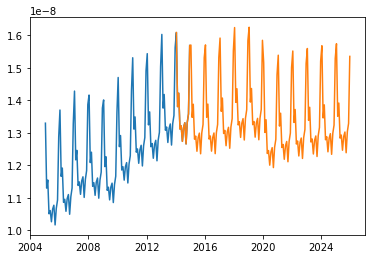

In [31]:
j=100
iplt.plot(co2_zon[:,j])
iplt.plot(co2_new_zon[:,j])

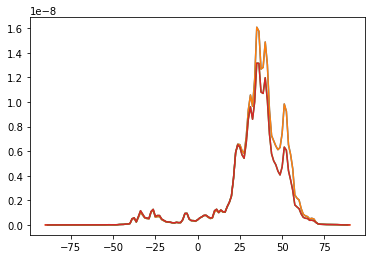

In [37]:
iplt.plot(co2_zon[-12])
iplt.plot(co2_new_zon[0])
iplt.plot(co2_zon[-6])
iplt.plot(co2_new_zon[6])

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/iris/coords.py:2048: UserWarning: Coordinate 'time' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/iris/coords.py:2048: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


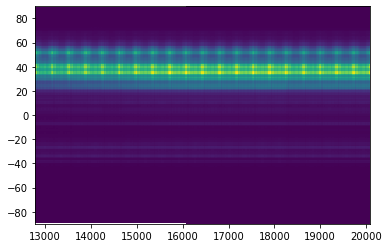

In [38]:
iplt.pcolormesh(co2_zon)
iplt.pcolormesh(co2_new_zon)